# Modeling

## Introduction

In this notebook, we finally get to explore some machine learning models in attempt to predict baseball pitch types. We have wrangled, explored, and processed Statcast data resulting in 3 datasets available for modeling:

- no_pitchers - All pitches without pitcher reference
- pitchers - All pitches with reference to top 5 pitchers based on pitch count
- first_pitch - Only the first pitch in each at-bat without pitcher reference

From here, we can explore modeling various scenarios with the data above. We'll begin by setting a baseline from predicting all pitches as the most common pitch type, FF. Our modeling efforts will include scaling the data, creating a train/test split, and evaluating performance metrics. We will also complete tuning of some hyperparameters relevant to each model. After creating a baseline prediction using sklearn's DummyClassifier, we'll work with a Decision Tree, Random Forest, and Support Vector Machine.

## Imports and Data Load

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree, metrics
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline, Pipeline

In [115]:
no_pitchers = pd.read_csv('no_pitchers.csv')
pitchers = pd.read_csv('pitchers.csv')
first_pitch = pd.read_csv('first_pitch.csv')

Given that we have split the data we've been working with, let's check to make sure we have enough observations (pitches) within each dataset.

In [158]:
print(no_pitchers.shape)
print(pitchers.shape)
print(first_pitch.shape)

(110301, 26)
(3114, 31)
(28166, 26)


We have plenty of pitches to work with. The 5 extra features in the 'pitchers' dataset are the 5 pitchers we kept and encoded.

## Train/Test Split

We begin with our first_pitch dataset containing only the first pitch of each at-bat in a given game.

In [159]:
first_pitch.head().T

,0,1,2,3,4
pitch_type,SL,FF,FF,SL,FF
balls,0,0,0,0,0
strikes,0,0,0,0,0
on_3b,0,0,0,0,0
on_2b,1,1,1,1,0
on_1b,1,0,0,0,1
outs_when_up,2,2,2,1,0
inning,9,9,9,9,9
at_bat_number,77,76,75,74,73
pitch_number,1,1,1,1,1


Let's define X and y, then check the partition sizes if we use a 70/30 train/test split.

In [160]:
X = first_pitch.drop(columns='pitch_type')
y = first_pitch['pitch_type']

In [161]:
len(first_pitch) * .7, len(first_pitch) * .3

(19716.199999999997, 8449.8)

In [288]:
#Creating train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [163]:
X_train.shape, X_test.shape

((19716, 25), (8450, 25))

In [164]:
y_train.shape, y_test.shape

((19716,), (8450,))

The shape of our train/test split aligns with expectations for a 70/30 train/test split. Let's check to make sure all or our features are of numeric type.

In [165]:
X_train.dtypes

balls                                   int64
strikes                                 int64
on_3b                                   int64
on_2b                                   int64
on_1b                                   int64
outs_when_up                            int64
inning                                  int64
at_bat_number                           int64
pitch_number                            int64
home_score                              int64
away_score                              int64
bat_score                               int64
fld_score                               int64
stand_L                                 int64
stand_R                                 int64
p_throws_L                              int64
p_throws_R                              int64
inning_topbot_Bot                       int64
inning_topbot_Top                       int64
if_fielding_alignment_Infield shift     int64
if_fielding_alignment_Standard          int64
if_fielding_alignment_Strategic   

In [166]:
X_test.dtypes

balls                                   int64
strikes                                 int64
on_3b                                   int64
on_2b                                   int64
on_1b                                   int64
outs_when_up                            int64
inning                                  int64
at_bat_number                           int64
pitch_number                            int64
home_score                              int64
away_score                              int64
bat_score                               int64
fld_score                               int64
stand_L                                 int64
stand_R                                 int64
p_throws_L                              int64
p_throws_R                              int64
inning_topbot_Bot                       int64
inning_topbot_Top                       int64
if_fielding_alignment_Infield shift     int64
if_fielding_alignment_Standard          int64
if_fielding_alignment_Strategic   

## Baseline
We begin with our baseline of predicting the most frequent pitch type (FF) for all pitches. Sklearn's DummyClassifier allows us to easily accomplish this.

In [271]:
dumb_class = DummyClassifier(strategy='constant', constant='FF')
dumb_class.fit(X_train, y_train)
dumb_class.constant

'FF'

In [272]:
#Confirming our predictions for the DummyClassifier are all 'FF'
y_train_pred = dumb_class.predict(X_test)
print(y_train_pred[:5])

['FF' 'FF' 'FF' 'FF' 'FF']


In [273]:
print(classification_report(y_test, y_train_pred, zero_division=0))

              precision    recall  f1-score   support

          CH       0.00      0.00      0.00       653
          CU       0.00      0.00      0.00       859
          FC       0.00      0.00      0.00       493
          FF       0.38      1.00      0.55      3216
          FS       0.00      0.00      0.00        63
          FT       0.00      0.00      0.00       800
          KC       0.00      0.00      0.00       249
          KN       0.00      0.00      0.00         4
          SI       0.00      0.00      0.00       771
          SL       0.00      0.00      0.00      1342

    accuracy                           0.38      8450
   macro avg       0.04      0.10      0.06      8450
weighted avg       0.14      0.38      0.21      8450



The classification report confirms our dummy classification model predicted only FF as it's the only class with non-zero values. The report also confirms FF is the most frequent pitch type as its support value is the largest. Both the precision and recall for FF are as expected given the accuracy of our positive predictions for FF, precision, should be equal to the ratio of FF to all, and our recall, or the percent of positives we predicted accurately, should be 100% or 1.0.

Due to the nature of the unbalanced classes in our multivariate classification problem, we will be focused on the macro avg f1-score for performance measurement of our models in addition to class specific performance. We're starting with a low bar of 0.06 for the f1-score macro avg. The accuracy of 0.38 alone is misleading because it doesn't reflect our inability to predict any class other than 'FF'. Let's move on to our first real model using sklearn's DecisionTreeClassifier.

## Decision Tree

Now that we have a baseline for comparison, let's move on by exploring a decision tree model. We'll begin with a tree using default parameter settings then move to explore the class_weight setting before tuning some parameters. Given a decision tree's tendancy to overfit, we will focus on pruning our tree with parameters such as max_depth and max_leaf_nodes. We also want to evaluate the resources required for each model by using the timeit cell magic.

In [305]:
%%timeit
#Default option: class_weight = none
#All classes are weighted evenly, so the model is considering individual errors of each prediction to be equally important. 
#This isn't great with inbalanced classes because the larger classes being predicted accurately will naturally happen more 
#often because there is more data there.

default_tree = tree.DecisionTreeClassifier()
default_tree.fit(X_train, y_train) 

107 ms ± 2.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let's try to visualize our default tree. The initial attempt required a kernel interruption due to the size and complexity of our tree. Our default tree is splitting until leaf nodes have a purity of 0, and with 11 pitch types (target variable) and 25 features, this will create a tree too large to visualize and one that is almost certainly overfitting. We can prune the tree for visualization by setting the max_depth within plot_tree.

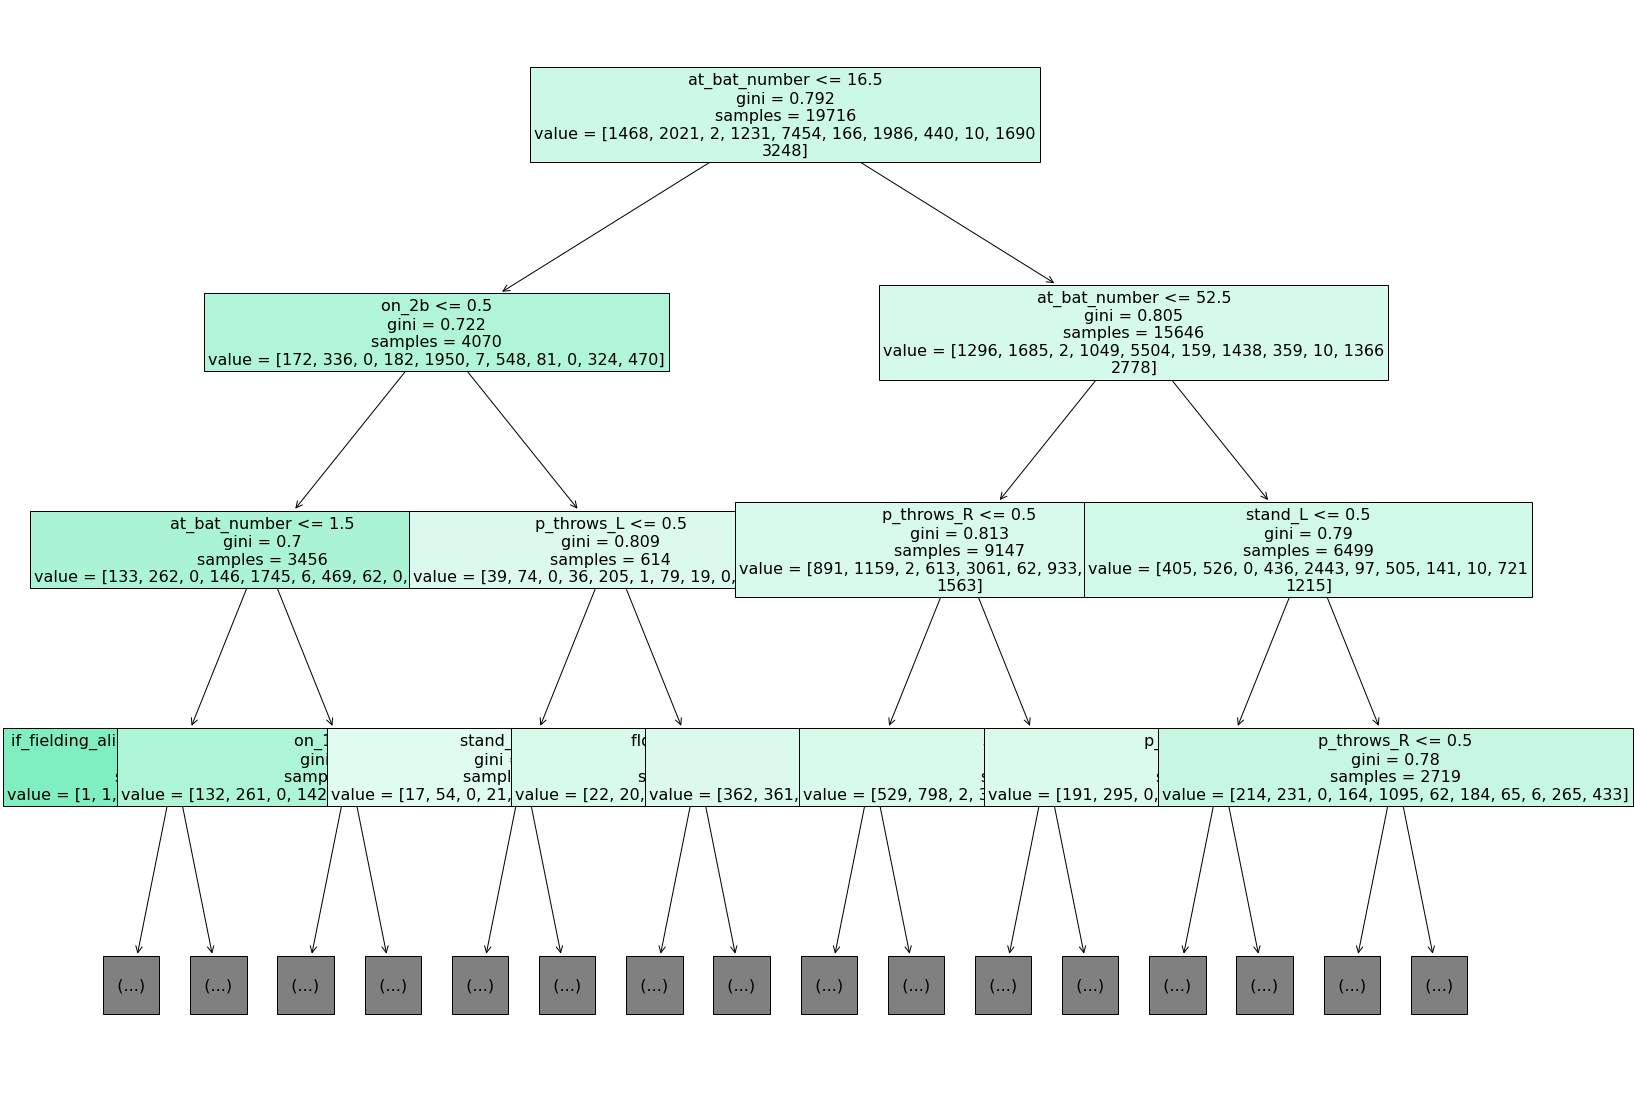

In [301]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(default_tree, 
                   feature_names=X_train.columns,  
                   max_depth=3,
                   fontsize=16,
                   filled=True);

The tree appears to give feature importance to the at_bat_number. We can explort this in greater detail later. For now, let's move on to explore if class_weight settings affects the performance of our model.

In [306]:
%%timeit
#Balanced classes: class_weight = balanced
#The classes are weighted according to the inverse of their frequency. This class weighting is better for highly inbalanced 
#classes because the errors made in the smaller classes are penalized more heavily than the errors made in the larger 
#classes. 

balanced_tree = tree.DecisionTreeClassifier(class_weight = 'balanced')
balanced_tree.fit(X_train, y_train) 

119 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [307]:
%%timeit
#Manual assignments to the classes - class weight = dictionary 
#Say a given batter has a lot of trouble hitting pitches categorized as "SL". We are going to weight that class more
#heavily than the other classes because we want to model to be especially accurate with that class. In other words, when 
#the model is splitting at the nodes, we want it to most heavily penalize incorrect predictions for the "SL" class. 
#We have given the "SL" class twice the weight as any other class.

#Creating the weighting dictionary
pitches = y_train.unique().tolist()
weights = [1] * len(pitches)
pitch_weight_dict = dict(zip(pitches, [1] * len(pitches)))
pitch_weight_dict['SL'] = 2

weighted_tree = tree.DecisionTreeClassifier(class_weight = pitch_weight_dict)
weighted_tree.fit(X_train, y_train) 

119 ms ± 3.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let's use the 3 models above to predict pitch types and then evaluate their performance using the respective classification reports.

In [221]:
default_pred = default_tree.predict(X_test)
print(classification_report(y_test, default_pred))

              precision    recall  f1-score   support

          CH       0.13      0.14      0.14       653
          CU       0.12      0.13      0.13       859
          FC       0.10      0.11      0.11       493
          FF       0.42      0.43      0.43      3216
          FS       0.03      0.03      0.03        63
          FT       0.11      0.11      0.11       800
          KC       0.07      0.05      0.06       249
          KN       0.00      0.00      0.00         4
          SI       0.12      0.11      0.12       771
          SL       0.21      0.20      0.21      1342

    accuracy                           0.25      8450
   macro avg       0.13      0.13      0.13      8450
weighted avg       0.25      0.25      0.25      8450



In [223]:
balanced_pred = balanced_tree.predict(X_test)
print(classification_report(y_test, balanced_pred, zero_division=0))

              precision    recall  f1-score   support

          CH       0.12      0.14      0.13       653
          CU       0.12      0.13      0.12       859
          EP       0.00      0.00      0.00         0
          FC       0.09      0.12      0.11       493
          FF       0.40      0.33      0.36      3216
          FS       0.03      0.05      0.04        63
          FT       0.13      0.16      0.14       800
          KC       0.05      0.06      0.06       249
          KN       0.00      0.00      0.00         4
          SI       0.16      0.17      0.17       771
          SL       0.22      0.21      0.22      1342

    accuracy                           0.22      8450
   macro avg       0.12      0.12      0.12      8450
weighted avg       0.24      0.22      0.23      8450



In [239]:
weighted_pred = weighted_tree.predict(X_test)
print(classification_report(y_test, weighted_pred, zero_division=0))

              precision    recall  f1-score   support

          CH       0.11      0.11      0.11       653
          CU       0.12      0.13      0.12       859
          EP       0.00      0.00      0.00         0
          FC       0.10      0.10      0.10       493
          FF       0.42      0.41      0.41      3216
          FS       0.03      0.03      0.03        63
          FT       0.12      0.13      0.13       800
          KC       0.07      0.05      0.06       249
          KN       0.00      0.00      0.00         4
          SI       0.15      0.13      0.14       771
          SL       0.18      0.21      0.19      1342

    accuracy                           0.24      8450
   macro avg       0.12      0.12      0.12      8450
weighted avg       0.24      0.24      0.24      8450



Starting with accuracy and macro avg f1-scores, we don't see much loss/gain in performance by varying the class weights. If anything, we see a class level decline by changing class weight from the default setting on None. We'll continue with the default setting for class_weight as we tune parameters. 

Let's change our criterion from gini to entropy and see how that affects performance:

In [322]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

          CH       0.13      0.14      0.14       615
          CU       0.13      0.13      0.13       871
          EP       0.00      0.00      0.00         1
          FC       0.11      0.12      0.11       509
          FF       0.43      0.42      0.43      3287
          FS       0.04      0.05      0.04        63
          FT       0.13      0.13      0.13       809
          KC       0.04      0.05      0.04       199
          KN       0.20      0.33      0.25         3
          SI       0.14      0.13      0.13       711
          SL       0.24      0.23      0.23      1382

    accuracy                           0.26      8450
   macro avg       0.14      0.16      0.15      8450
weighted avg       0.26      0.26      0.26      8450



We see a slight improvement to our performance at the macro and class levels! What if we start pruning by limiting the number of leaf nodes or features?

In [295]:
clf = tree.DecisionTreeClassifier(max_depth=6, max_leaf_nodes=10, max_features=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred, zero_division=0))

              precision    recall  f1-score   support

          CH       0.00      0.00      0.00      1506
          CU       0.00      0.00      0.00      2009
          EP       0.00      0.00      0.00         1
          FC       0.00      0.00      0.00      1215
          FF       0.37      1.00      0.54      7383
          FS       0.00      0.00      0.00       166
          FT       0.00      0.00      0.00      1977
          KC       0.00      0.00      0.00       490
          KN       0.00      0.00      0.00        11
          SI       0.00      0.00      0.00      1750
          SL       0.00      0.00      0.00      3208

    accuracy                           0.37     19716
   macro avg       0.03      0.09      0.05     19716
weighted avg       0.14      0.37      0.20     19716



In [289]:
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

          CH       0.00      0.00      0.00       615
          CU       0.00      0.00      0.00       871
          EP       0.00      0.00      0.00         1
          FC       0.00      0.00      0.00       509
          FF       0.39      1.00      0.56      3287
          FS       0.00      0.00      0.00        63
          FT       0.00      0.00      0.00       809
          KC       0.00      0.00      0.00       199
          KN       0.00      0.00      0.00         3
          SI       0.00      0.00      0.00       711
          SL       0.00      0.00      0.00      1382

    accuracy                           0.39      8450
   macro avg       0.04      0.09      0.05      8450
weighted avg       0.15      0.39      0.22      8450



When using a max_depth parameter less than 5, our model results in a single class prediction and effectively behaves like our dummy classifier. The decision tree model in conjunction with our statcast pitch data does not appear to have very good predictive power. This might be an indicator that the model is overfitting the training data. I will predict the accuracy of the model when predicting the training data in order to evaluate this suspicion.

In [264]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred, zero_division=0))

              precision    recall  f1-score   support

          CH       0.93      0.97      0.95      1468
          CU       0.91      0.96      0.93      2021
          EP       1.00      1.00      1.00         2
          FC       0.94      0.95      0.95      1231
          FF       0.91      0.98      0.94      7454
          FS       1.00      0.98      0.99       166
          FT       0.95      0.83      0.89      1986
          KC       0.97      0.90      0.93       440
          KN       1.00      1.00      1.00        10
          SI       0.98      0.87      0.92      1690
          SL       0.99      0.91      0.95      3248

    accuracy                           0.94     19716
   macro avg       0.96      0.94      0.95     19716
weighted avg       0.94      0.94      0.94     19716



Wow! The accuracy is so high compared to our test results that it's evident our model is overfitting. In an attempt to reduce overfitting, we want to stop growing the trees earlier. We tried this above with max_depth and showed it did not work. Next, we will try a random forest because they aggregate many decision trees to limit overfitting as well as error due to bias.

## Random Forest
Let's see if an ensemble method for decision trees can help improve our accuracy. We will use a RandomForestClassifier within a pipeline that is also scaling the data, in addition to cross-validation and grid search for hyperparameter tuning.

In [265]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=42))

In [266]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

C:\Users\Louie\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [270]:
print(rf_default_cv_results)

{'fit_time': array([1.79812455, 1.74097657, 1.7282002 , 1.71128893, 1.71613455]), 'score_time': array([0.11486149, 0.11299729, 0.11299992, 0.11200023, 0.11530948]), 'test_score': array([0.30806288, 0.30839462, 0.31803196, 0.31093076, 0.30864824])}


In [267]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.30806288, 0.30839462, 0.31803196, 0.31093076, 0.30864824])

In [268]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.3108136919665065, 0.003747668161533341)

In [139]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestclassifier__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
}
grid_params

{'randomforestclassifier__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(copy=True, with_mean=True, with_std=True),
  None]}

In [141]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)

C:\Users\Louie\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                   

In [142]:
rf_grid_cv.best_params_

{'randomforestclassifier__n_estimators': 297,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [145]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

C:\Users\Louie\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


array([0.32023327, 0.30636571, 0.31143799, 0.32234339, 0.31321329])

In [146]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.31471873024267205, 0.005854026184189302)

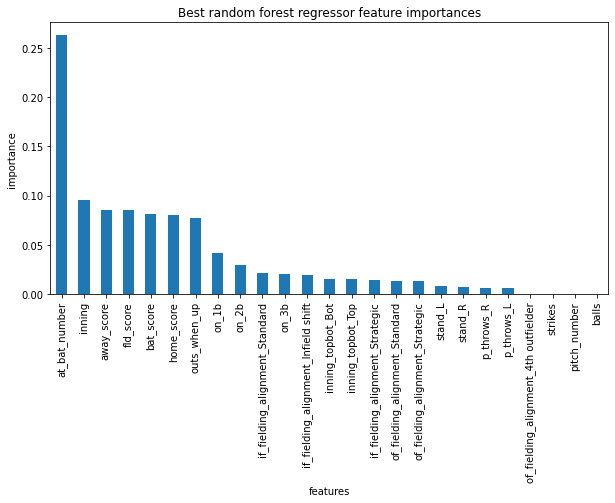

In [148]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestclassifier.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [73]:
pipe.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=-1,
                                        oob_score=False, random_state=42,
                                        verbose=1, warm_start=False))],
         verbose=False

In [74]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [78]:
print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

          CH       0.18      0.15      0.16       615
          CU       0.16      0.11      0.13       871
          EP       0.00      0.00      0.00         1
          FC       0.15      0.08      0.10       509
          FF       0.42      0.61      0.50      3287
          FS       0.13      0.05      0.07        63
          FT       0.15      0.10      0.12       809
          KC       0.05      0.03      0.03       199
          KN       1.00      0.67      0.80         3
          SI       0.19      0.11      0.14       711
          SL       0.24      0.21      0.22      1382

    accuracy                           0.32      8450
   macro avg       0.24      0.19      0.21      8450
weighted avg       0.27      0.32      0.29      8450



## Support Vector Machine

In [103]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [104]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

          CH       0.00      0.00      0.00       615
          CU       0.00      0.00      0.00       871
          EP       0.00      0.00      0.00         1
          FC       0.00      0.00      0.00       509
          FF       0.39      1.00      0.56      3287
          FS       0.00      0.00      0.00        63
          FT       0.00      0.00      0.00       809
          KC       0.00      0.00      0.00       199
          KN       0.00      0.00      0.00         3
          SI       0.00      0.00      0.00       711
          SL       0.00      0.00      0.00      1382

    accuracy                           0.39      8450
   macro avg       0.04      0.09      0.05      8450
weighted avg       0.15      0.39      0.22      8450



In [155]:
first_pitch.head()

,pitch_type,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,inning,at_bat_number,pitch_number,...,p_throws_L,p_throws_R,inning_topbot_Bot,inning_topbot_Top,if_fielding_alignment_Infield shift,if_fielding_alignment_Standard,if_fielding_alignment_Strategic,of_fielding_alignment_4th outfielder,of_fielding_alignment_Standard,of_fielding_alignment_Strategic
0,SL,0,0,0,1,1,2,9,77,1,...,1,0,0,1,0,1,0,0,1,0
1,FF,0,0,0,1,0,2,9,76,1,...,1,0,0,1,0,1,0,0,1,0
2,FF,0,0,0,1,0,2,9,75,1,...,1,0,0,1,0,1,0,0,1,0
3,SL,0,0,0,1,0,1,9,74,1,...,1,0,0,1,0,1,0,0,1,0
4,FF,0,0,0,0,1,0,9,73,1,...,1,0,0,1,0,1,0,0,1,0
